This is just a first attempt without splitting train/val/test and overfitting analysis.

### 1. Load modules

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from dpk import koopman_probabilistic, model_objs
import glob
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pandas as pd
# %matplotlib notebook

### 2. Data manipulation

1. read the data
2. rescale the data
3. create fixed dt time vector
3. make new data array with NaNs for missing data

In [2]:
#1: read data
ff = glob.glob("./DVV_TEST/*RIO*")[0]
pd_dv = pd.read_csv(ff)
pd_dv.head()

,DATE,DVV,CC
0,1999-10-21,-0.765280,0.875691
1,1999-10-25,-0.759454,0.862668
2,1999-10-26,-0.802919,0.867514
3,1999-10-28,-0.934312,0.876715
4,1999-10-29,-1.474492,0.880135


In [3]:
# 2: data rescaling
crap=pd_dv['DVV']
Yraw = crap.to_numpy().reshape(-1, 1)
scale = np.std(Yraw)
loc = np.mean(Yraw)
Y = (Yraw - loc) / scale

In [4]:
# 3: time vector
#Convert pandas datetime into numpy timestamp
dates = np.array(pd.to_datetime(pd_dv['DATE']))
tt = (pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 86400) # array of time stamps in seconds, but these are sampled each 10 day

In [5]:
# create the new data and fill with NaNs for the missing data points
# x = pd.date_range(min(dates),periods=20*365,freq="D")
# x = x[x<max(dates)] # until the last
# # print(max(dates))
# xx= pd.to_datetime(x).values.astype(np.int64) // 10 ** 9 // 86400 


# crap1=(tt[-1]*86400*10**9).astype('<M8[ns]')
# print(crap1)



# crap2=(xx[-1]*86400*10**9).astype('<M8[ns]')
# print(crap2)

# print(crap1<crap2)

# print( pd.to_datetime(t[-1]*86400*10**9).values.astype(np.datetime)) 

In [6]:
# # now fill the data gap
# YY = np.zeros(len(xx),dtype=np.float)
# YY.fill(np.nan)
# for ii,iy in enumerate(xx): # loop from the ideal time stamp in days
#     ik=np.where(tt==iy)[0]
#     if ik>0:
#         YY[ii]=Y[ik[0]][0]
# print(YY[:100])

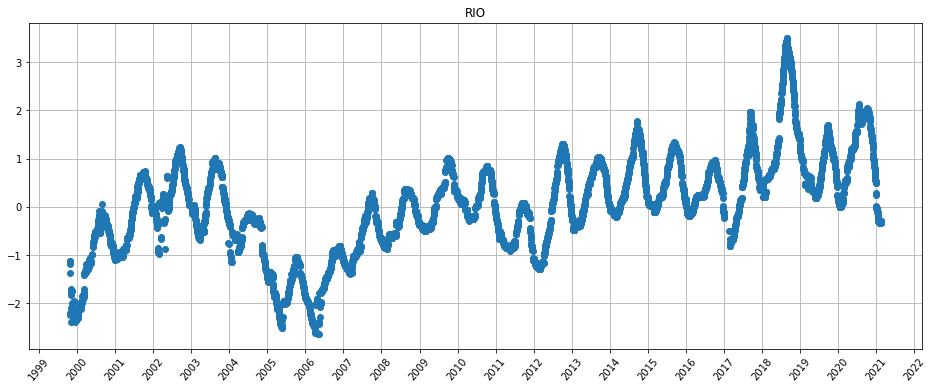

In [7]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot_date(dates,Y)
# ax.plot_date(x,YY)
ax.set_title('RIO')
xx=plt.xticks(rotation=50)
fmt_half_year = mdates.YearLocator()
ax.xaxis.set_major_locator(fmt_half_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.set_yticks([0])
# ax.set_yticklabels(['dv/v'])
ax.grid(True)
# plt.plot(np.arange(len(pd_dv['DVV'])),pd_dv['DVV']);plt.grid(True)

## Work with evenly spaced data
fill in gaps just to make it a better dv/v time series
oversample it to test the accuracy

In [8]:
# interpolate data, maybe it's missing data points? let's try one hour time sample
from scipy.interpolate import interp1d
%matplotlib inline
tt = (pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 86400) # array of time stamps in days for the original data
tt_h = (pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 3600) # array of time stamps in days for the original data
x = pd.date_range(min(dates),periods=22*365*24,freq="H")# new "dates" but sampled per hour
x = x[x<max(dates)] # until the last day of record.
xx= pd.to_datetime(x).values.astype(np.int64) // 10 ** 9 // 3600 # convert new array to time stamp, 1 index per hour
crap1=np.zeros(len(tt_h))
crap2=np.zeros(len(tt_h))
crap1[:] = np.array(tt_h)
for i in range(len(tt_h)):
    crap2[i]=Y[i]
crap3 = interp1d(crap1,crap2)
Ynew = crap3(xx)

In [9]:
# rescale data
Ynew=Ynew.reshape(-1,1)
scale = np.std(Ynew)
loc = np.mean(Ynew)
Ynew2 = (Ynew - loc) / scale

In [11]:
# define a model
periods = [365*24,365*24*6]  # 1 year of time period, in hourly units
model_obj = model_objs.SkewNormalNLL(x_dim=Ynew2.shape[1], num_freqs=len(periods), num_covariates=1)
print(model_obj)

SkewNormalNLL(
  (l1_mu): Linear(in_features=5, out_features=256, bias=True)
  (l2_mu): Linear(in_features=256, out_features=64, bias=True)
  (l3_mu): Linear(in_features=64, out_features=1, bias=True)
  (l1_sig): Linear(in_features=5, out_features=256, bias=True)
  (l2_sig): Linear(in_features=256, out_features=64, bias=True)
  (l3_sig): Linear(in_features=64, out_features=1, bias=True)
  (l1_a): Linear(in_features=5, out_features=256, bias=True)
  (l2_a): Linear(in_features=256, out_features=64, bias=True)
  (l3_a): Linear(in_features=64, out_features=1, bias=True)
)


In [16]:
# train the model
k = koopman_probabilistic.KoopmanProb(model_obj, device='cpu')
k.init_periods(periods)
k.fit(Ynew2, covariates=np.arange(Ynew2.shape[0]).reshape(-1, 1), iterations=20, weight_decay=1e-6, verbose=True) # avoid overfitting with weight_decay = 1e-4


Iteration  0
tensor([ 8760., 52560.,  8760., 52560.,  8760., 52560.])


KeyboardInterrupt: 

In [17]:
# PREDICT and rescale data
params = k.predict(T=30*365*24, covariates=np.arange(30*365*24).reshape(-1, 1))
params = model_obj.rescale(loc, scale, params)
loc_hat, scale_hat, alpha_hat = params
x_hat = model_obj.mean(params)
std_hat = model_obj.std(params)

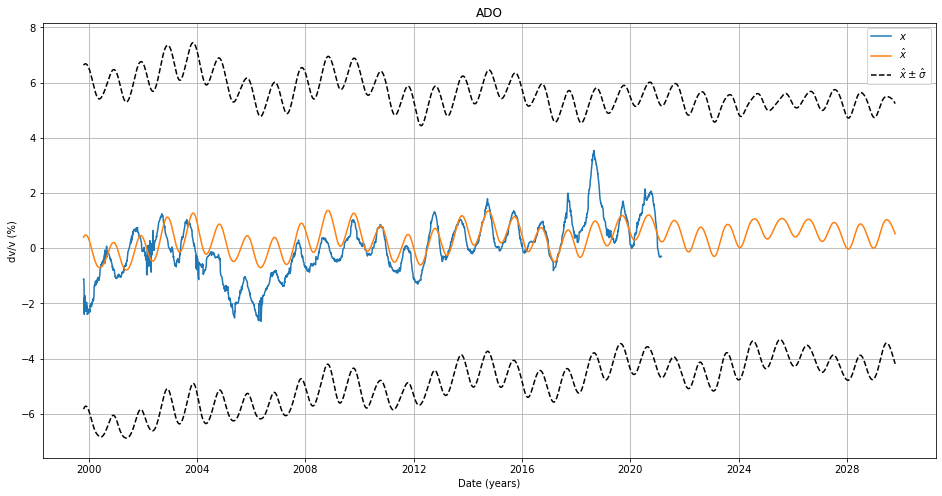

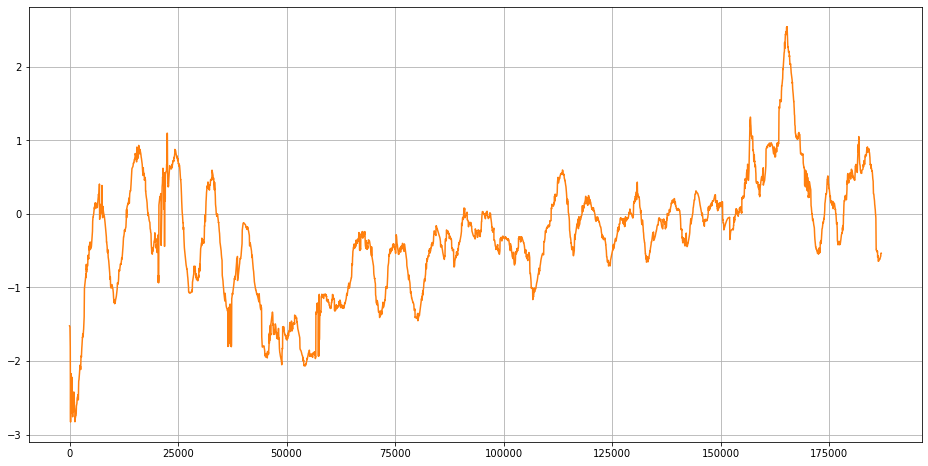

In [18]:
%matplotlib inline
# make time vector of predictios
T2=pd.date_range(min(dates),periods=30*365*24,freq="H")#.to_pydatetime()

# plot

ax=plt.figure(figsize=(16,8))
plt.plot_date(x,Ynew2, "tab:blue", label="$x$")
plt.plot_date(T2,x_hat, "tab:orange", label="$\hat x$")
plt.plot_date(T2,x_hat + std_hat, "--k", label="$\hat x \pm \hat \sigma$")
plt.plot_date(T2,x_hat - std_hat, "--k")
# plt.xlim([1_000, 200_000])
# ax.set_ylim([-5,5])
plt.legend()
plt.xlabel('Date (years)')
plt.title('ADO')
plt.ylabel('dv/v (%)')
plt.grid(True)
plt.savefig('test_ADO.png')
plt.show()


ax=plt.figure(figsize=(16,8))
plt.plot(Ynew-x_hat[:len(x)], "tab:orange", label="$\hat x$")
plt.grid(True)
plt.show()


# plt.plot(x_hat)
# plt.plot(x_hat)
# plt.show()

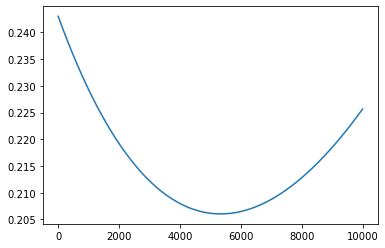

In [25]:
import torch
inpt = torch.cat([torch.zeros((10000,4)),torch.linspace(0,1,10000)[:,None]],-1)
inpt = torch.cat([inpt,inpt,inpt], -1)
outp = k.model_obj.decode(inpt)[1].detach().numpy()
plt.plot(outp)